In [ ]:
!git clone https://github.com/tomtaranto/GeneticAlgoPrez

In [ ]:
%cd GeneticAlgoPrez

In [29]:
MUTATION_RATE = 0.1
POPULATION_SIZE = 800
NEW_ELEMENTS_EACH_GENERATION = 10
GENERATIONS = 1001
SELECTION_FUNCTION = 'rank'
PLOT_BEST_EVERY = 10
PLOT_DIR = 'plots'
DATASET = "paris_metro"  # Available values: "random", "paris_metro"
NUMBER_OF_CITIES = 332 if DATASET == "paris_metro" else 50

In [30]:
if NEW_ELEMENTS_EACH_GENERATION % 2 != 0:
    raise ValueError(
        'NEW_ELEMENTS_EACh_GENERATION must be multiple of 2. Dealing with other population size is not implemented yet.')
if NEW_ELEMENTS_EACH_GENERATION > POPULATION_SIZE / 2:
    raise ValueError(
        'NEW_ELEMENTS_EACh_GENERATION must be smaller than POPULATION_SIZE/2. Dealing with other population size is not implemented yet.')
if POPULATION_SIZE % 4 != 0:
    raise ValueError(
        'Population size must be multiple of 4. Dealing with other population size is not implemented yet.')
if PLOT_BEST_EVERY > GENERATIONS:
    raise ValueError(f'PLOT_BEST_EVERY should be smaller than GENERATIONS. ')


In [31]:
import time

import numpy as np
import pandas as pd
from tqdm import tqdm

from my_types import ArrayNx1, ArrayKx2xM, ArrayNxM, ArrayMx2
from plot_utils import save_best, save_gif, clear_plots

In [34]:

def generate_cities_coordinates() -> ArrayMx2[float]:
    if DATASET == "random":
        return np.random.rand(NUMBER_OF_CITIES, 2)
    elif DATASET == "paris_metro":
        df = pd.read_csv("datasets/metro-france.csv", sep=";")
        df = df[df["Commune nom"].str.contains("Paris")]
        cities = df[["Latitude", "Longitude"]].to_numpy()
        print(len(cities))
        return cities



In [35]:
def generate_initial_population(n: int = POPULATION_SIZE) -> ArrayNxM[int]:
    return np.vstack([np.random.permutation(np.arange(NUMBER_OF_CITIES)) for _ in range(n)])


In [36]:
def evaluate(population: ArrayNxM[int], cities_coordinates: ArrayMx2[float]) -> ArrayNx1[float]:
    paths = cities_coordinates[population]
    distances = np.linalg.norm(paths[:, 1:] - paths[:, :-1], axis=2)
    scores = np.sum(distances, axis=1)
    return scores

In [37]:
def selection(population: ArrayNxM[int], scores: ArrayNx1[float], function: str) -> ArrayKx2xM[int]:
    sorted_indices = np.argsort(scores)
    sorted_population = population[sorted_indices]
    if function == 'rank':
        kept_individuals = sorted_population[:int(POPULATION_SIZE / 2)]
        np.random.shuffle(kept_individuals)
        return kept_individuals.reshape(-1, 2, kept_individuals.shape[1])
    elif function == 'roulette':
        pass
    elif function == 'tournament':
        pass
    else:
        raise ValueError(f'Unknown selection function: {function}')

In [38]:
def crossover(parents: ArrayKx2xM[int]) -> ArrayKx2xM[int]:
    children = np.empty_like(parents)
    for i, parent in enumerate(parents):
        father, mother = parent[0], parent[1]
        child1, child2 = np.empty_like(father), np.empty_like(mother)
        middle = int(NUMBER_OF_CITIES / 2)
        child1[:middle] = father[:middle]
        child1[middle:] = np.setdiff1d(mother, child1[:middle])
        child2[middle:] = father[middle:]
        child2[:middle] = np.setdiff1d(mother, child2[middle:])
        children[i] = np.vstack([child1, child2])
    return children

In [39]:
def mutation(children: ArrayKx2xM[int]) -> ArrayKx2xM[int]:
    for child in children:
        child1, child2 = child[0], child[1]
        if np.random.rand() < MUTATION_RATE:
            i = np.random.choice(NUMBER_OF_CITIES - 1)
            child1[[i, i + 1]] = child1[[i + 1, i]]
        if np.random.rand() < MUTATION_RATE:
            i = np.random.choice(NUMBER_OF_CITIES - 1)
            child2[[i, i + 1]] = child2[[i + 1, i]]
    return children

In [40]:
def replacement(parents: ArrayKx2xM[int], children: ArrayKx2xM[int]) -> ArrayNxM[int]:
    new_elements = generate_initial_population(NEW_ELEMENTS_EACH_GENERATION)
    number_of_not_kept_parents = int(NEW_ELEMENTS_EACH_GENERATION / 2)
    return np.vstack((parents[:-number_of_not_kept_parents, 0, :],
                      parents[:-number_of_not_kept_parents, 1, :],
                      children[:, 0, :],
                      children[:, 1, :],
                      new_elements))


In [41]:
def perform_genetic_algorithm():
    clear_plots()
    start_time = time.time()
    city_coordinates = generate_cities_coordinates()
    population = generate_initial_population()
    best_score = np.inf
    iteration_reaching_best_score = 0
    for i in tqdm(range(GENERATIONS)):
        scores = evaluate(population, city_coordinates)
        if i % PLOT_BEST_EVERY == 0:
            best_score = np.argmin(scores)
            save_best(population[best_score], city_coordinates, scores[best_score], i)
        if np.min(scores) < best_score:
            best_score = np.min(scores)
            iteration_reaching_best_score = i
        parents = selection(population, scores, SELECTION_FUNCTION)
        children = crossover(parents)
        children = mutation(children)
        population = replacement(parents, children)
    print(f"reached best score at iteration {iteration_reaching_best_score}")
    print(f'Total time: {time.time() - start_time}')
    save_gif()

332


100%|██████████| 1001/1001 [00:28<00:00, 35.17it/s]


reached best score at iteration 1000
Total time: 28.471612215042114


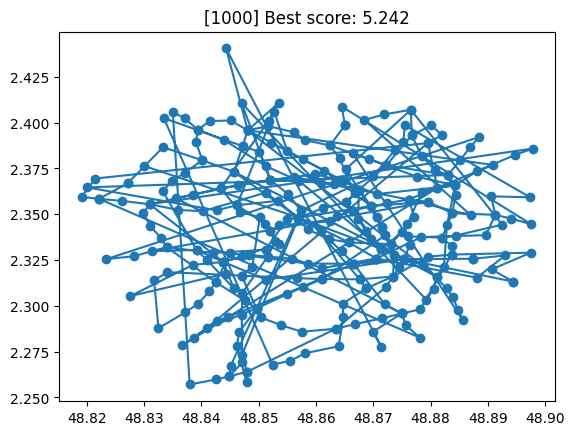

In [42]:
perform_genetic_algorithm()

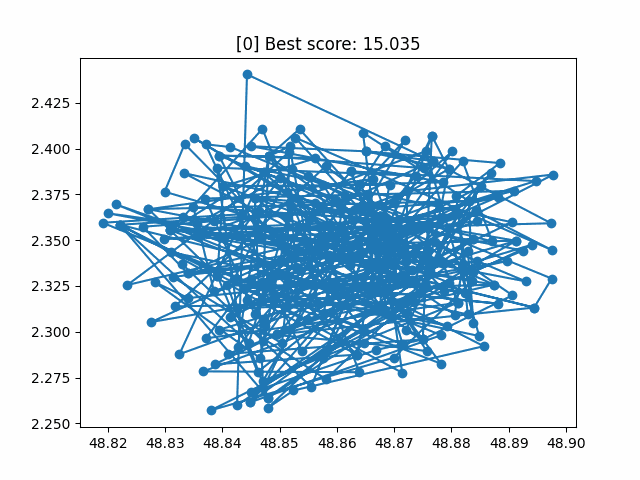

In [43]:
from IPython.display import Image
Image(open('animation.gif','rb').read())